In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Part 1 - Prepare SQLAlchemy 

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)
measurement_df = pd.read_sql('SELECT * FROM measurement', conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [7]:
station_df = pd.read_sql('SELECT * FROM station', conn)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Part 2 - Exploratory Climate Analysis

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
One_year_ago = '2016-08-23'
prec_12 = pd.read_sql(f"SELECT prcp, date From measurement where date >= '{One_year_ago}' order by date", conn)

prec_12.sort_values(by='date', ascending=False)
prec_12.set_index('date', inplace=True)

prec_12.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


Text(0, 0.5, 'Inches')

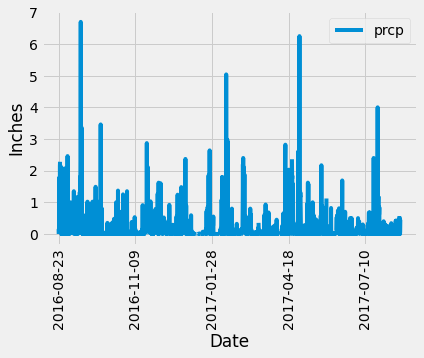

In [56]:
prec_12.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
prec_12.describe()

,prcp
count,3336.000000
mean,0.174559
std,0.487085
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,9.640000


In [28]:
# Design a query to show how many stations are available in this dataset?
station_no = pd.read_sql('select count(station) from station', conn)
station_no

,count(station)
0,9


In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query ='''
    select
        station,
        count(*) as station_count
    from
        measurement
    group by
        station
    order by station_count desc
''' 

station_no = pd.read_sql(query, conn)
station_no.head(10)

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query_min_max_avg = pd.read_sql("select max(tobs), min(tobs), avg (tobs)from measurement where station = 'USC00519281'", conn)
query_min_max_avg

,max(tobs),min(tobs),avg (tobs)
0,85.0,54.0,71.663781


In [35]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_12 = pd.read_sql("SELECT tobs From measurement where date >= '2016-08-23' and station = 'USC00519281'", conn)
tobs_12.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


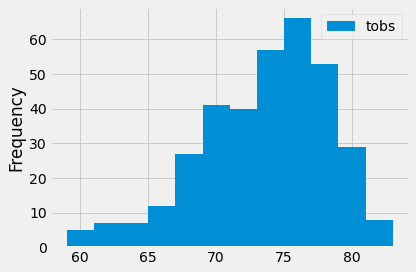

In [36]:
tobs_12.plot.hist(bins=12)
plt.tight_layout()

## Part 3 - Data Analysis Assignment

In [58]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    query = f'''
        SELECT	
            MIN(tobs) AS min_tobs,
            MAX(tobs) AS max_tobs,
            AVG(tobs) AS avg_tobs
        FROM	
            measurement
        WHERE
            date BETWEEN '{start_date}' AND '{end_date}'
    '''
    temp_stats_df = pd.read_sql(query, conn)
    temp_stats = tuple(temp_stats_df.values[0])
    return temp_stats
# function usage example
print(calc_temps('2017-01-01', '2017-12-31'))

(58.0, 87.0, 74.14387974230493)


In [59]:
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 74.0, 69.57142857142857)


In [65]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-04-02','2017-04-09')
trip_temps

(67.0, 79.0, 74.42)

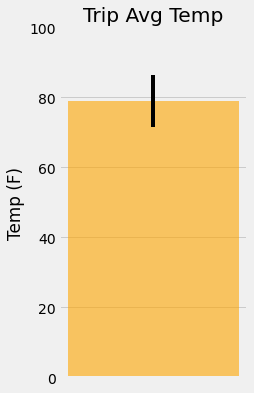

In [68]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = trip_temps[0]
avg_temp = trip_temps[1]
max_temp = trip_temps[2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(3,6))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'orange', alpha=.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])

plt.show()

In [79]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
yearly_rainfall = pd.read_sql("Select s.station, s.name, s.latitude, s.longitude, s.elevation, AVG(m.prcp) FROM measurement m Inner Join Station s on m.station=s.station Where date >= '2017-04-02' group by s.station, m.prcp", conn)
yearly_rainfall.head()



,station,name,latitude,longitude,elevation,AVG(m.prcp)
0,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,0.00
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,0.01
2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,0.02
3,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,0.03
4,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,0.04


In [94]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """
    
    # your code here
    query = f'''
        SELECT	
            MIN(tobs) AS min_tobs,
            MAX(tobs) AS max_tobs,
            AVG(tobs) AS avg_tobs
        FROM	
            measurement
        WHERE
            date == '{date}'
    '''
    daily_df = pd.read_sql(query, conn)
    
    
    return daily_df
    
daily_normals("01-01")

,min_tobs,max_tobs,avg_tobs
0,None,None,None


In [95]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_dates = ["08-04", "08-05", "08-06", "08-07", "08-08", "08-09", "08-10", "08-11", "08-12", "08-13", "08-14",
             "08-15", "08-16", "08-17", "08-18"]

daily_norms = []

for trip_date in trip_dates:
    day = {}
    day['Date'] = f"2016-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['Min'] = daily_norm
    day['Avg'] = daily_norm
    day['Max'] = daily_norm
    daily_norms.append(day)
    
daily_norms

[{'Date': '2016-08-04',
  'Min':   min_tobs max_tobs avg_tobs
  0     None     None     None,
  'Avg':   min_tobs max_tobs avg_tobs
  0     None     None     None,
  'Max':   min_tobs max_tobs avg_tobs
  0     None     None     None},
 {'Date': '2016-08-05',
  'Min':   min_tobs max_tobs avg_tobs
  0     None     None     None,
  'Avg':   min_tobs max_tobs avg_tobs
  0     None     None     None,
  'Max':   min_tobs max_tobs avg_tobs
  0     None     None     None},
 {'Date': '2016-08-06',
  'Min':   min_tobs max_tobs avg_tobs
  0     None     None     None,
  'Avg':   min_tobs max_tobs avg_tobs
  0     None     None     None,
  'Max':   min_tobs max_tobs avg_tobs
  0     None     None     None},
 {'Date': '2016-08-07',
  'Min':   min_tobs max_tobs avg_tobs
  0     None     None     None,
  'Avg':   min_tobs max_tobs avg_tobs
  0     None     None     None,
  'Max':   min_tobs max_tobs avg_tobs
  0     None     None     None},
 {'Date': '2016-08-08',
  'Min':   min_tobs max_tobs avg_tob

In [91]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(daily_norms)

daily_norms_df.set_index('Date', inplace = True)

daily_norms_df

,Min,Avg,Max
Date,,,
2019-08-04,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...
2019-08-05,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...
2019-08-06,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...
2019-08-07,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...
2019-08-08,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...
2019-08-09,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...
2019-08-10,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...
2019-08-11,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...
2019-08-12,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...,min_tobs max_tobs avg_tobs 0 None No...


TypeError: no numeric data to plot

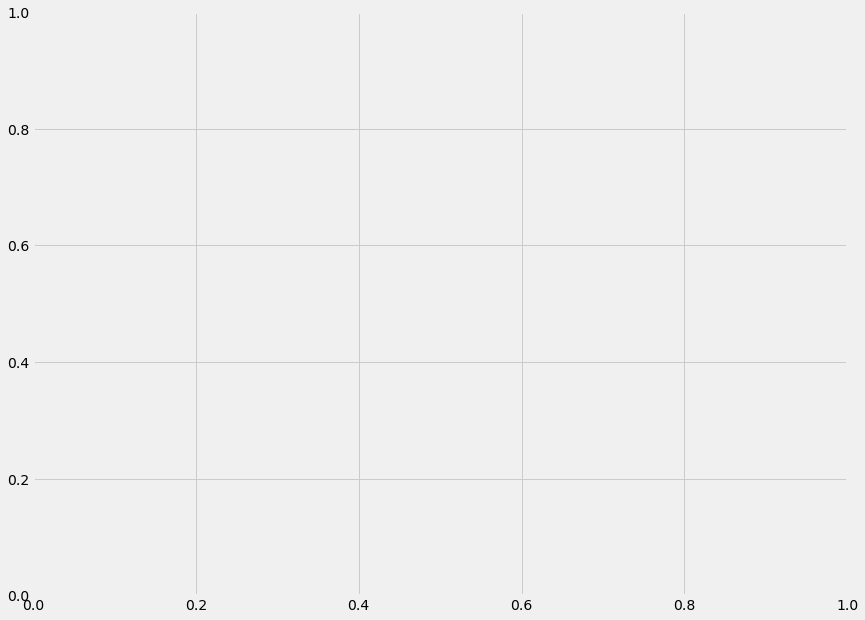

In [92]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, HI')

#set ticks
dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

#save figure
plt.savefig('Images/dailynormarea.png')

#show
plt.grid()
plt.tight_layout()
plt.show()